# **Laboratorio 4 - Informe**
### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## **1. Inicializaciones**

#### **1.1 Bibliotecas**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### **1.2 Preprocesamiento**

En el siguiente bloque dividimos el dataset en conjuntos de train y test (80/20), y el conjunto de train lo dividimos en conjunto de entrenamienton y validación (90/10). Además, removemos los features *pidnum* y *time*, esta última por consigna.

In [2]:
data = pd.read_csv('dataset.csv')

def init(data):
    data = data.drop(columns=['pidnum','time'])
    train, test = train_test_split(data, test_size=0.2, random_state=0)
    train_90, val = train_test_split(train, test_size=0.1, random_state=0)
    return train, train_90, val, test

target = 'cid'

train, train_90, val, test = init(data)


In [3]:
X_final_train, y_final_train = train.drop(columns=[target]), train[target]
X_train, y_train = train_90.drop(columns=[target]), train_90[target]
X_val, y_val = val.drop(columns=[target]), val[target]
X_test, y_test = test.drop(columns=[target]), test[target]

En el dataset original, múltiples atributos se encuentran en diferentes escalas. Por ejemplo, el atributo *age* se encuentra en un rango de 0 a 100, mientras que el atributo *chol* se encuentra en un rango de 100 a 400, o el atributo *cd820* que llega a tomar valores por encima de 1000. Esto puede provocar que la red le atribuya "mayor importancia" a ciertos atributos de mayor valor, lo que no representa la realidad. Por esto, es necesario estandarizar los datos, o sea, transformar los valores de entrada (dataset) con tal de obtener una varianza de 1 y media de 0. Para ello, utilizamos la clase StandardScaler de la librería scikit-learn, que estanda. De esta manera, todo atributo mantiene la misma importancia que el resto.

Sin embargo, previo a la estandarización, es necesario aplicar One-hot Encoding sobre todo atributo categórico de más de dos valores, que en este caso es solamente *trt*, .

In [4]:
discrete_features = ['trt']
continuous_features = [
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820',
    'karnof'
]

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X_train[discrete_features].to_numpy())

for feat in discrete_features:
    # Transform the training and test data using the fitted OneHotEncoder
    # Converts the categorical feature in X_train and X_test to one-hot encoded format
    new_final_train = ohe.transform(X_final_train[feat].to_numpy().reshape(-1,1))
    new_train = ohe.transform(X_train[feat].to_numpy().reshape(-1,1))
    new_val = ohe.transform(X_val[feat].to_numpy().reshape(-1,1))
    new_test = ohe.transform(X_test[feat].to_numpy().reshape(-1,1))
    
    # Create column names for the new one-hot encoded features
    column_names = [f"{feat}_{cat}" for cat in ohe.categories_[0]]
    
    """ for i, col_name in enumerate(column_names):
        # Add the new one-hot encoded columns to the X_train and X_test DataFrame
        X_final_train[col_name] = new_final_train[:, i]
        X_train[col_name] = new_train[:, i]
        X_val[col_name] = new_val[:, i]
        X_test[col_name] = new_test[:, i] """
    X_final_train = pd.concat([X_final_train, pd.DataFrame(new_final_train, columns=column_names, index=X_final_train.index)], axis=1)
    X_train = pd.concat([X_train, pd.DataFrame(new_train, columns=column_names, index=X_train.index)], axis=1)
    X_val = pd.concat([X_val, pd.DataFrame(new_val, columns=column_names, index=X_val.index)], axis=1)
    X_test = pd.concat([X_test, pd.DataFrame(new_test, columns=column_names, index=X_test.index)], axis=1)
    
    
    X_final_train.drop(feat, axis=1, inplace=True)
    X_train.drop(feat, axis=1, inplace=True)
    X_val.drop(feat, axis=1, inplace=True)
    X_test.drop(feat, axis=1, inplace=True)

scaler = StandardScaler()
scaler.fit(X_train[continuous_features])

X_train[continuous_features] = scaler.transform(X_train[continuous_features])
X_val[continuous_features] = scaler.transform(X_val[continuous_features])
X_final_train[continuous_features] = scaler.transform(X_final_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

input_size = X_train.shape[1]


Modelo 1

In [5]:
def train_logistic_regression(X_train, y_train, X_val, y_val):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    return model, accuracy


In [11]:
model1, accuracy_val = train_logistic_regression(X_train, y_train, X_val, y_val)

print(f"Accuracy del Modelo 1 en el conjunto de validación: {accuracy_val:.4f}")


Accuracy del Modelo 1 en el conjunto de validación: 0.8198


Función de entrenamiento

In [7]:
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=100, lr=0.01, criterion='CrossEntropyLoss', modelNumber=2, weight_decay=0.0):
    # Loss function
    if (criterion == 'CrossEntropyLoss'):
        loss_fn = torch.nn.CrossEntropyLoss()
    elif (criterion == 'BCELoss'): 
        loss_fn = torch.nn.BCELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [], []
    
    for epoch in range(epochs):
        model.train()

        # Forward pass
        y_train_pred = model(X_train_tensor)
        loss = loss_fn(y_train_pred, y_train_tensor)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Training metrics
        if (modelNumber == 2):
            predicted = torch.argmax(y_train_pred, dim=1)
        else:
            predicted = y_train_pred.round()
            
        train_acc = (predicted == y_train_tensor).float().mean().item()
        
        train_loss.append(loss.item())
        train_accuracy.append(train_acc)
        
        # Validation metrics
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            if (modelNumber == 2):
                val_predicted = torch.argmax(val_outputs, dim=1)
            else:
                val_predicted = (val_outputs >= 0.5).float()
            val_acc = (val_predicted == y_val_tensor).float().mean().item()
        
        # Store metrics
        val_loss.append(loss_fn(val_outputs, y_val_tensor).item())
        val_accuracy.append(val_acc)
    
    return train_loss, val_loss, train_accuracy, val_accuracy

epochs = 100
learning_rate = 0.01


Función de plotteo

In [8]:
epochs_list = range(0, epochs)

def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(12, 5))
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_loss, label='Train Loss')
    plt.plot(epochs_list, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Gráfico de accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracy, label='Train Accuracy')
    plt.plot(epochs_list, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Modelo 2

In [9]:
class SimpleLinearNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleLinearNN, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        self.eval()
        
        with torch.no_grad():
            logits = self.forward(x)
            _, predicted_classes = torch.max(logits, 1)
        
        return predicted_classes


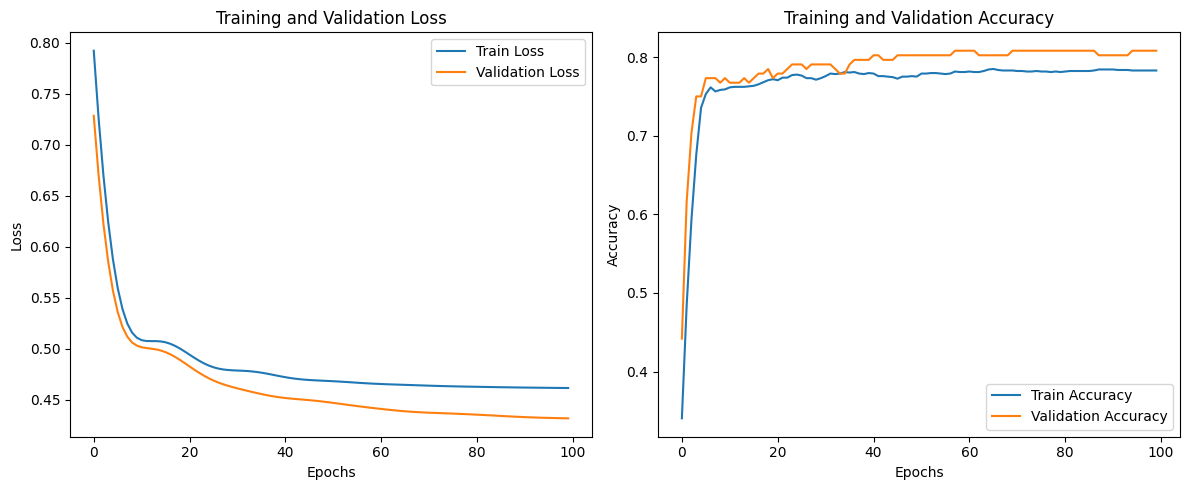

In [13]:
model2 = SimpleLinearNN(input_size)

X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.LongTensor(y_val.values)

train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model2,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='CrossEntropyLoss',
    modelNumber=2
)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

Modelo 3

In [14]:
class SigmoidNN(nn.Module):
    def __init__(self, input_size):
        super(SigmoidNN, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions


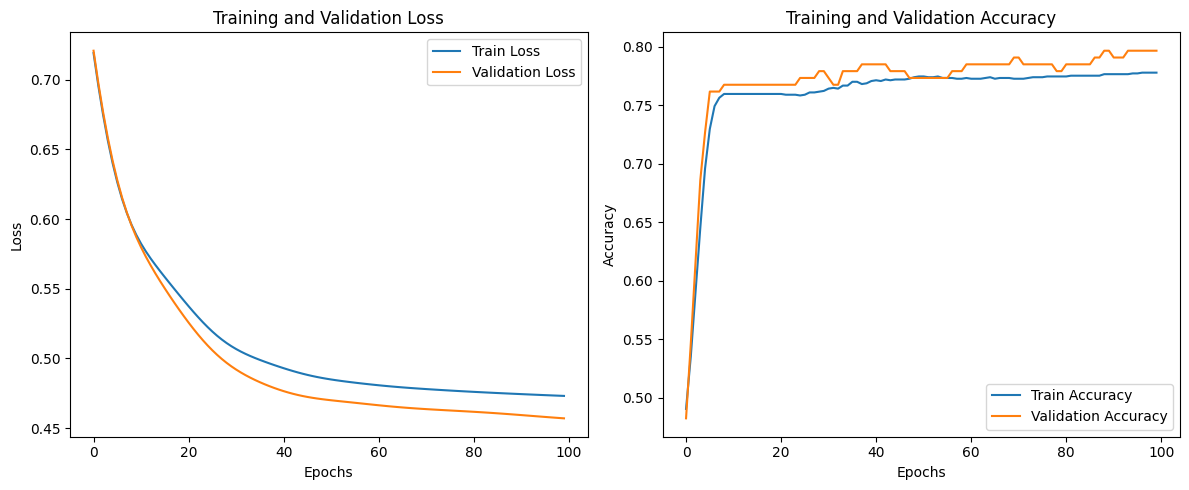

In [17]:
model3 = SigmoidNN(input_size)
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1) # explicar
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model3,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='BCELoss',
    modelNumber=3
)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

Modelo 4

In [20]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.hidden = nn.Linear(input_size, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions
    

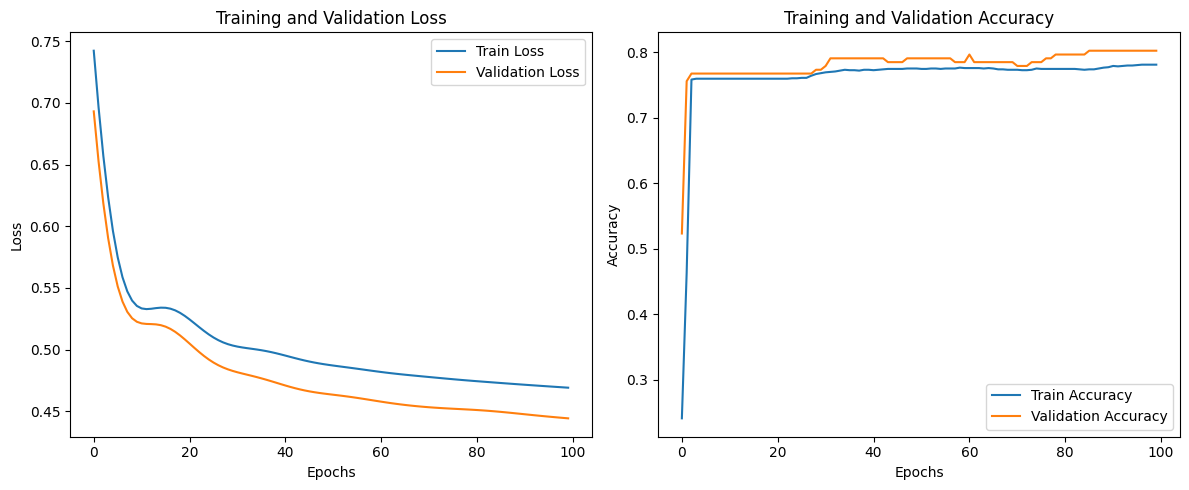

In [26]:
model4 = FeedForwardNN(input_size)
train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model4,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='BCELoss',
    modelNumber=4
)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

Modelo 5

In [27]:
class ModelA(nn.Module):
    def __init__(self, input_size):
        super(ModelA, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions

class ModelB(nn.Module):
    def __init__(self, input_size):
        super(ModelB, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions

class ModelC(nn.Module):
    def __init__(self, input_size):
        super(ModelC, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.01)
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions


In [28]:
models = {
    "ModelA": None,
    "ModelB": None,
    "ModelC": None
}

learning_rates = [0.01, 0.001, 0.0001]
results = {}

# Entrenar y evaluar cada modelo con diferentes tasas de aprendizaje
for model_name, model in models.items():
    for lr in learning_rates:
        if model_name == "ModelA":
            model = ModelA(input_size)
        elif model_name == "ModelB":
            model = ModelB(input_size)
        elif model_name == "ModelC":
            model = ModelC(input_size)
        train_loss, val_loss, train_accuracy, val_accuracy = train_model(
            model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
            lr=lr, epochs=epochs, weight_decay=0.01 if model_name == "ModelC" else 0.0, criterion='BCELoss' ,modelNumber=5
        )
        
        # Guardar los resultados
        results[(model_name, lr)] = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "f1_score": f1_score(y_val_tensor, model.predict(X_val_tensor), average='weighted')
        }


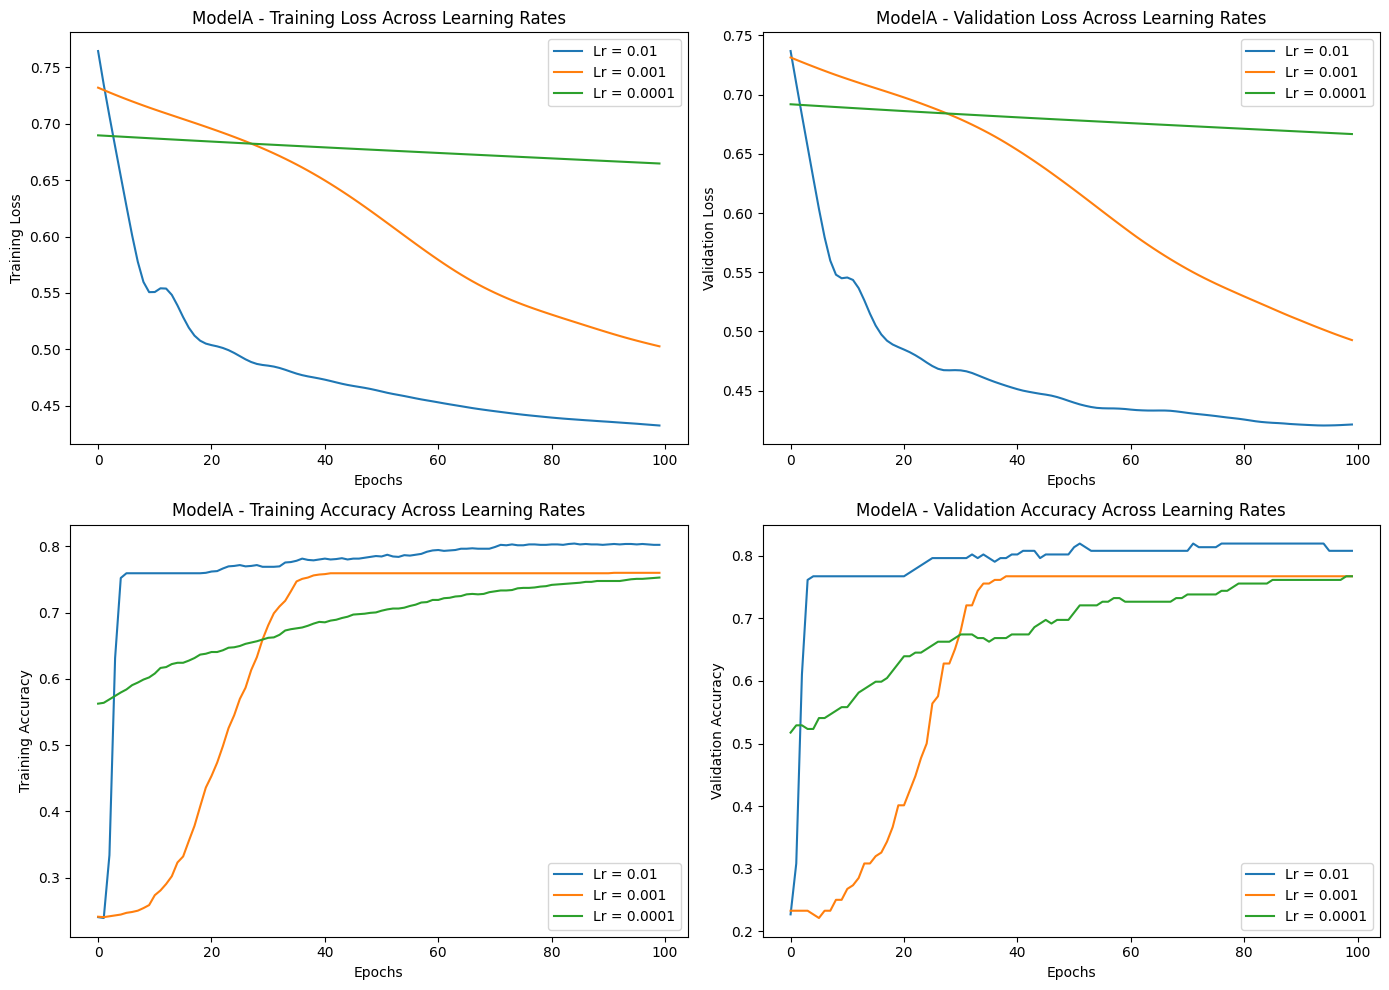

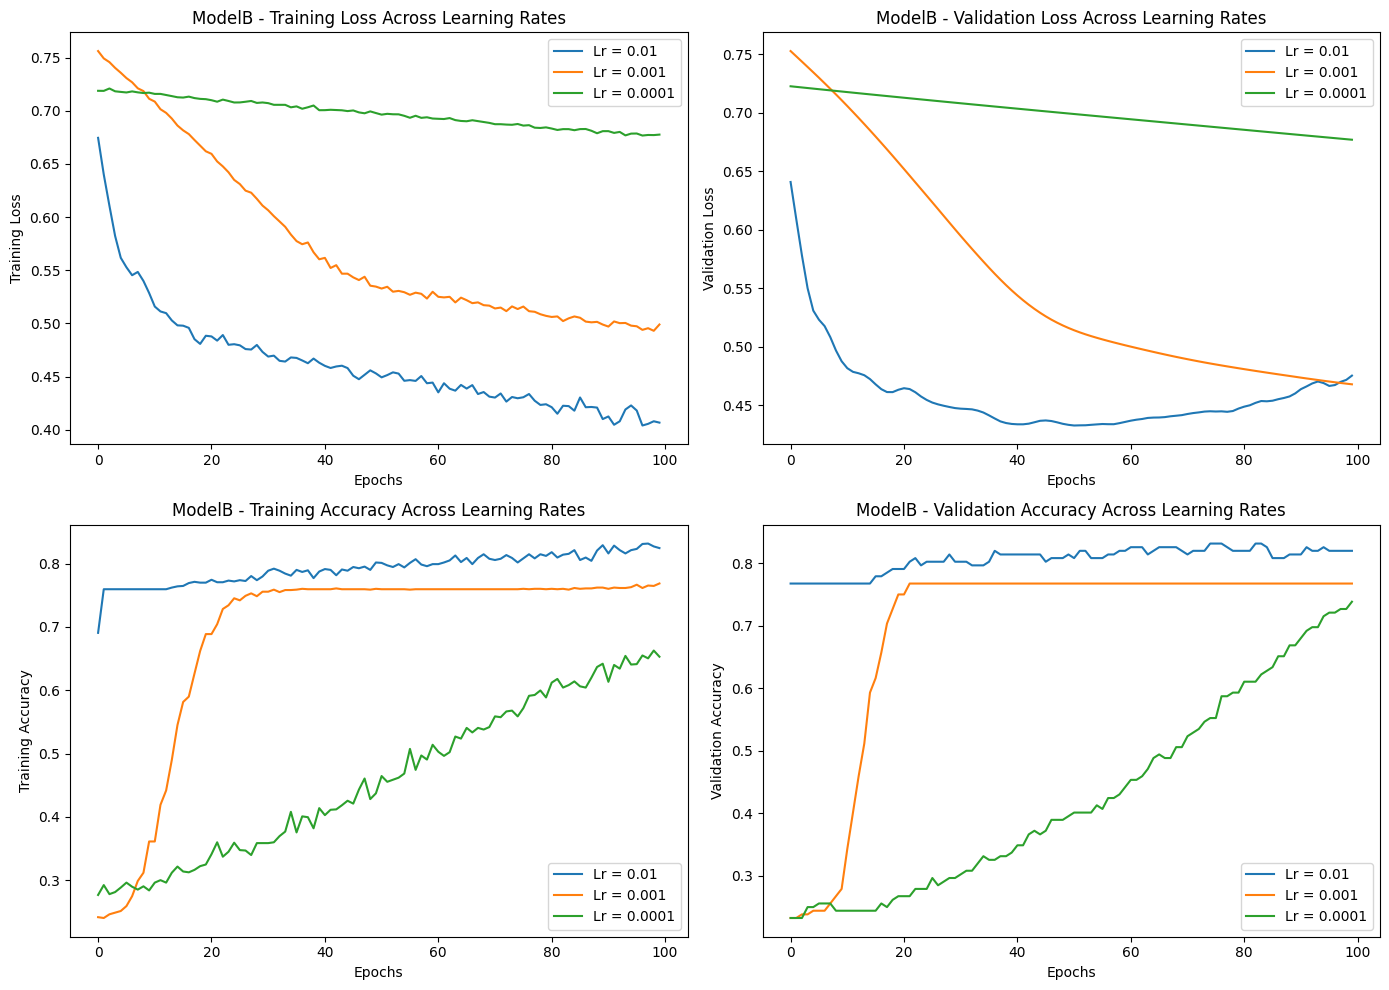

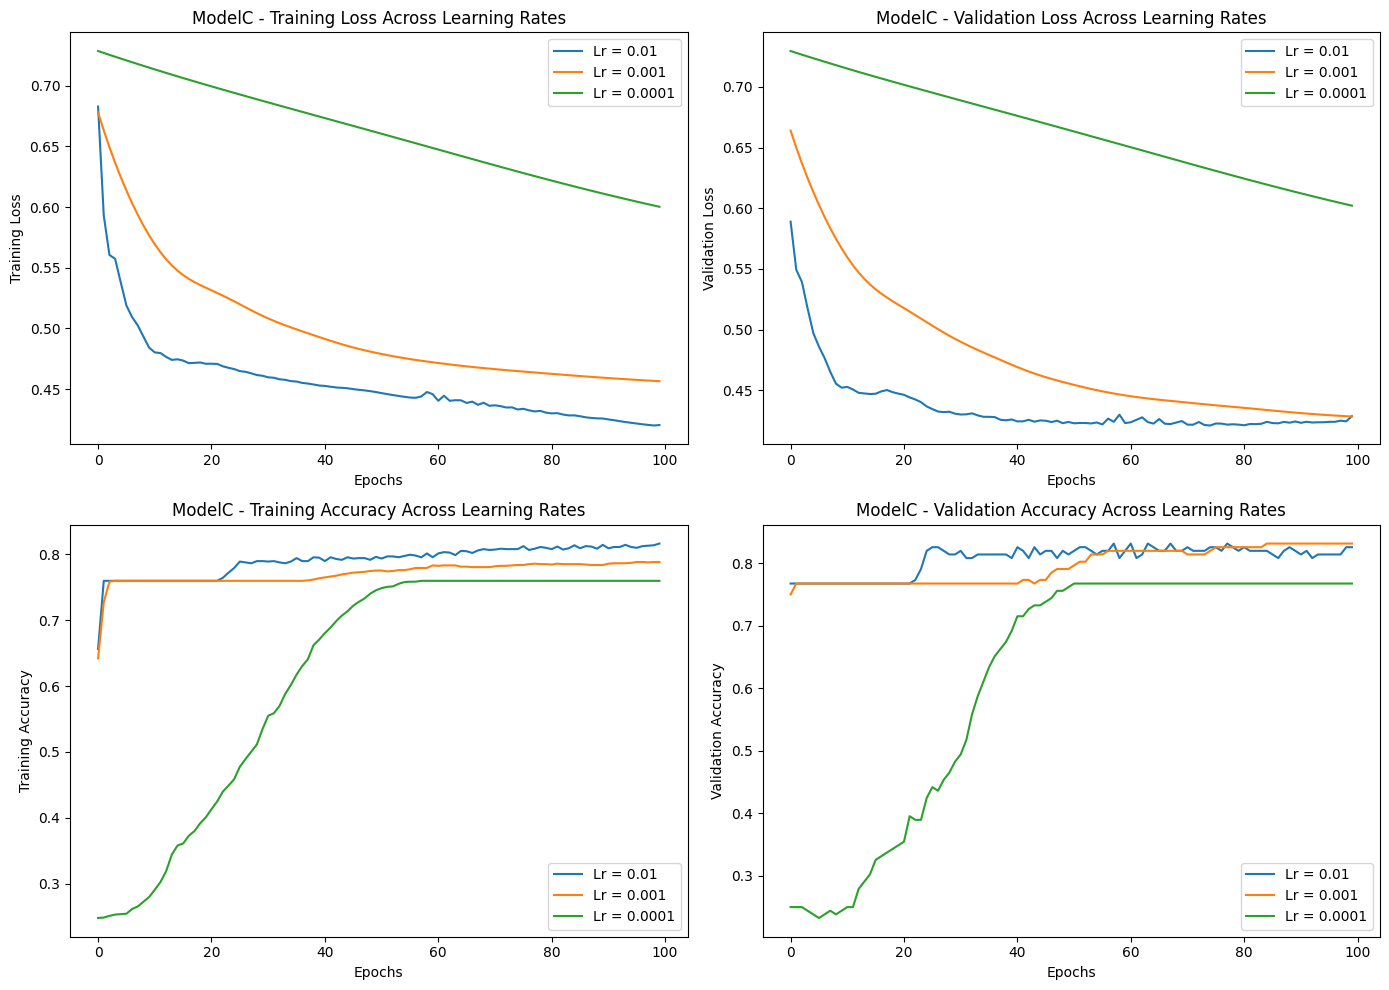

In [29]:
def plot_model_metrics_across_learning_rates(results):
    # Extract unique model names
    model_names = ['ModelA', 'ModelB', 'ModelC']
    
    # Plot for each model
    for model_name in model_names:
        # Initialize lists to hold data for each learning rate
        epochs_list = None
        all_train_loss, all_val_loss = {}, {}
        all_train_accuracy, all_val_accuracy = {}, {}
        
        # Collect data for all learning rates for the current model
        for (name, lr), metrics in results.items():
            if name == model_name:
                # Initialize epoch list only once
                if epochs_list is None:
                    epochs_list = range(0, len(metrics["train_loss"]))
                
                all_train_loss[lr] = metrics["train_loss"]
                all_val_loss[lr] = metrics["val_loss"]
                all_train_accuracy[lr] = metrics["train_accuracy"]
                all_val_accuracy[lr] = metrics["val_accuracy"]

        # Plot Training and Validation Loss for all learning rates
        plt.figure(figsize=(14, 10))
        
        # Training Loss
        plt.subplot(2, 2, 1)
        for lr, train_loss in all_train_loss.items():
            plt.plot(epochs_list, train_loss, label=f'Lr = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        plt.title(f'{model_name} - Training Loss Across Learning Rates')
        plt.legend()
        
        # Validation Loss
        plt.subplot(2, 2, 2)
        for lr, val_loss in all_val_loss.items():
            plt.plot(epochs_list, val_loss, label=f'Lr = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Loss')
        plt.title(f'{model_name} - Validation Loss Across Learning Rates')
        plt.legend()

        # Training Accuracy
        plt.subplot(2, 2, 3)
        for lr, train_accuracy in all_train_accuracy.items():
            plt.plot(epochs_list, train_accuracy, label=f'Lr = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Training Accuracy')
        plt.title(f'{model_name} - Training Accuracy Across Learning Rates')
        plt.legend()
        
        # Validation Accuracy
        plt.subplot(2, 2, 4)
        for lr, val_accuracy in all_val_accuracy.items():
            plt.plot(epochs_list, val_accuracy, label=f'Lr = {lr}')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        plt.title(f'{model_name} - Validation Accuracy Across Learning Rates')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function with the results dictionary
plot_model_metrics_across_learning_rates(results)


In [30]:
records = [{"Model": model, "Learning Rate": lr, "F1 Score": metrics["f1_score"]} 
           for (model, lr), metrics in results.items()]

# Convertir la lista en un DataFrame
results_df = pd.DataFrame(records)

# Encontrar el modelo con el mejor F1 Score
best_model = results_df.loc[results_df["F1 Score"].idxmax()]

# Mostrar la tabla completa de resultados
print("Tabla de Resultados:")
print(results_df)

# Mostrar el mejor modelo
print("\nMejor Modelo:")
print(best_model)

Tabla de Resultados:
    Model  Learning Rate  F1 Score
0  ModelA         0.0100  0.788057
1  ModelA         0.0010  0.666463
2  ModelA         0.0001  0.666463
3  ModelB         0.0100  0.797749
4  ModelB         0.0010  0.666463
5  ModelB         0.0001  0.651941
6  ModelC         0.0100  0.799210
7  ModelC         0.0010  0.800369
8  ModelC         0.0001  0.666463

Mejor Modelo:
Model              ModelC
Learning Rate       0.001
F1 Score         0.800369
Name: 7, dtype: object


Evaluación

In [31]:
def evaluate_model(model, X_test, y_test):
    if isinstance(X_test, pd.DataFrame):
        X_test = torch.tensor(X_test.values, dtype=torch.float32)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [36]:
model1Final, _ = train_logistic_regression(X_final_train, y_final_train, X_test, y_test)

model2Final = SimpleLinearNN(input_size=input_size)
X_final_train_tensor = torch.FloatTensor(X_final_train.values)
y_final_train_tensor = torch.LongTensor(y_final_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)
_ = train_model(model2Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='CrossEntropyLoss',modelNumber=2)

model3Final = SigmoidNN(input_size=input_size)
X_final_train_tensor = torch.FloatTensor(X_final_train.values)
y_final_train_tensor = torch.FloatTensor(y_final_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)
_ = train_model(model3Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=3)

model4Final = FeedForwardNN(input_size=input_size)
_ = train_model(model4Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=4)

# Mejor modelo de los 3 que propusimos
model5lr = best_model['Learning Rate']
model5Final = ModelB(input_size=input_size)
_ = train_model(model5Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, model5lr, criterion='BCELoss', modelNumber=5)


In [38]:
results_list = []
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
models = [model1Final, model2Final, model3Final, model4Final, model5Final]
X_test = torch.FloatTensor(X_test.values)
for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    
    results_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

results_df = pd.DataFrame(results_list)

print(results_df)
print("Learning rate del Modelo 5: ", model5lr)

     Model  Accuracy  Precision    Recall        F1
0  Model 1  0.778037   0.761249  0.778037  0.740672
1  Model 2  0.785047   0.785606  0.785047  0.738604
2  Model 3  0.768692   0.760673  0.768692  0.710608
3  Model 4  0.782710   0.774125  0.782710  0.740700
4  Model 5  0.740654   0.548569  0.740654  0.630302
Learning rate del Modelo 5:  0.001


/home/francisco/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/francisco/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
